In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division
import os
import time
import copy
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
import scipy.ndimage as ndi
from pathlib import Path
from PIL import Image
import io
import json
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [4]:
imagesFolder = '/content/gdrive/MyDrive/Tesis/Imagenes/ADNI-MUESTRA-930'
trainDatasetCSV = imagesFolder + '/MUESTRA_train.csv'
valDatasetCSV =   imagesFolder + '/MUESTRA_val.csv'
experimentName = 'Muestra930_1_Full'
experimentOutputFolder = '/content/gdrive/MyDrive/Tesis/Experimentos/muestra930_1'
experimentDescription = 'Muestra930 sin feature extract'
executions = 1

In [5]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 10

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

usePretrained = True

learningRate = 0.0001

crossEntrophyWeigths = torch.tensor([1.0,1.0,1.0])

slicesToCut = 0

# Data augmentation
dataAugmentation = {
    "angle": 13.0,
    "zoom": 0.15,
    "shiftX": 10.0,
    "shiftY": 10.0,
    "angleTransformChance": 0.1,
    "zoomTransformChance": 0.1,
    "shiftTransformChance": 0.0
}
dataAugmentation = {}

validationCacheSize = 400
trainCacheSize = 700

In [6]:
f = open(os.path.join(experimentOutputFolder, experimentName + "_params.txt"), "w")
f.write("batch_size: " + str(batch_size) + "\n")
f.write("epochs: " + str(num_epochs) + "\n")
f.write("feature_extract: " + str(feature_extract) + "\n")
f.write("usePretrained: " + str(usePretrained) + "\n")
f.write("learningRate: " + str(learningRate) + "\n")
f.write("cross entrophy weights: " + str(crossEntrophyWeigths) + "\n")
f.write("slicesToCut: " + str(slicesToCut) + "\n")
f.write("dataAugmentation: " + str(json.dumps(dataAugmentation)) + "\n")
f.write("executions: " + str(executions) + "\n")
f.write("validationCacheSize: " + str(validationCacheSize) + "\n")
f.write("trainCacheSize: " + str(trainCacheSize) + "\n")
f.close()

In [7]:
f = open(os.path.join(experimentOutputFolder, experimentName + "_descripcion.txt"), "w")
f.write(experimentDescription)
f.close()

In [8]:
# https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, facecolor='black', dpi = 64, transparent=False) # dpi Requerido para que la imagen sea 512x512
    buf.seek(0)
    img = Image.open(buf)
    return img

In [9]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [10]:
def transformGridImage(sample, angle = None, zoom = None, shiftX = None, shiftY = None, 
                        angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1):
    brain_vol_data = sample.get_fdata()
    fig_rows = 4
    fig_cols = 4
    n_subplots = fig_rows * fig_cols
    n_slice = brain_vol_data.shape[2]

    slices_to_eliminate = slicesToCut

    n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos n slices
    n_slice = n_slice - slices_to_eliminate

    step_size = n_slice / n_subplots

    slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')
    
    if angle == None or angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
        
    if zoom != None and random.uniform(0.0, 1.0) > zoomTransformChance:
        zoom = None
        
    if shiftX != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftX = None
        
    if shiftY != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftY = None

    idx = 0
    for img in slice_indices:
        processedImage = ndi.rotate(brain_vol_data[:, :, round(img)], 90.0 + angle)
        if zoom != None:
            processedImage = clipped_zoom(processedImage, zoom)
        if shiftX != None:
            processedImage = ndi.shift(processedImage, [0.0, shiftX, 0.0])
        if shiftY != None:
            processedImage = ndi.shift(processedImage, [shiftY, 0.0, 0.0])
        axs.flat[idx].imshow(np.squeeze(processedImage), cmap='gray')
        axs.flat[idx].axis('off')
        idx += 1
        
    plt.tight_layout()

    image = fig2img(fig)

    plt.close(fig) # Para que no muestre la imágen
    
    return image

In [11]:
# CreateGrid transform
class CreateGrid(object):
    """Creates a grid from the image
    """
    def __init__(self, transformArgs = {}):
        self.transformArgs = transformArgs

    def __call__(self, sample):
        return transformGridImage(sample, **self.transformArgs)

In [12]:
class RemoveTransparency(object):
    def __call__(self, sample):
      # La imagen se guarda con transparencia, removemos la dimension de indice 3
      return sample[0:3, :, :]

In [13]:
class ToLabelOutput(object):
    def __call__(self, label):
        if label == "CN":
            return 0
        elif label == "AD":
            return 1
        else:
            return 2 # MCI, LMCI, EMCI

In [14]:
class ADNIDataset(Dataset):
    """ADNI dataset."""

    def __init__(self, csv_file, root_dir, transform=None, target_transform = None, cacheSize = 200):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        # file cache almacena las rutas a cada item
        self.filename_cache = [None] * len(self)
        # item_cache directamente almacena los items procesados
        self.cacheSize = cacheSize
        self.item_cache = [None] * cacheSize

    def __len__(self):
      return int(len(self.csv))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] != None:
            item = self.item_cache[idx % self.cacheSize]
            if item["id"] == idx:
                # item in cache
                return item["image"], item["label"]
            
        studyID = self.csv.iloc[idx, 0]
        subjectID = self.csv.iloc[idx, 1]
        processFormat = self.csv.iloc[idx, 7]
        date = self.csv.iloc[idx, 9]
        diagnosis = self.csv.iloc[idx, 2]
        
        filename = self.filename_cache[idx]
        
        if filename == None:
            rglob = '*'+str(studyID)+'*.nii'
            samples = 0

            for path in Path(self.root_dir).rglob(rglob):
                filename = str(path)
                samples =+ 1
            
            if samples > 1:
                raise "Mas de un sample. Error"

            self.filename_cache[idx] = filename

        if not filename:
            raise Exception("Not found filename for index " + str(idx) + " y studyID " + studyID)
            
        brain_vol = nib.load(filename)

        image = brain_vol
        label = diagnosis
        
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        if self.cacheSize > 0 and self.item_cache[idx % self.cacheSize] == None:
            # Storing item in cache
            self.item_cache[idx % self.cacheSize] = {
                "id": idx,
                "label": label,
                "image": image
            }

        return image, label

In [15]:
def printFile(text, file):
  print(text)
  if file != None:
      file.write(text + "\n")

# Modelo

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=True, logFile = None):
    f = None
    if logFile != None:
        f = open(logFile, "w")

    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        printFile('Epoch {}/{}'.format(epoch, num_epochs - 1), f)
        printFile('-' * 10, f)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        # No usamos el aux
                        #outputs, aux_outputs = model(inputs)
                        #loss1 = criterion(outputs, labels)
                        #loss2 = criterion(aux_outputs, labels)
                        #loss = loss1 + 0.4*loss2
                        outputs, aux_outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            printFile('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), f)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            

    time_elapsed = time.time() - since
    printFile('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), f)
    printFile('Best val Acc: {:4f}'.format(best_acc), f)

    # load best model weights
    model.load_state_dict(best_model_wts)
    if logFile != None:
        f.close()
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initialize and reshape inception

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained, 
                                       aux_logits = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        # num_ftrs = model_ft.AuxLogits.fc.in_features
        # model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        print("num featurs" + str(num_ftrs))
        # Fuente: https://github.com/bdrad/petdementiapub/blob/master/petdementia_source.py
        model_ft.fc = nn.Sequential(
          nn.Linear(num_ftrs,1024),
          nn.ReLU(),
          nn.Linear(1024,num_classes),
        )
          
        input_size = 512 

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=usePretrained)

# Print the model we just instantiated
# print(model_ft)

num featurs2048


In [19]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        CreateGrid(dataAugmentation),
        transforms.ToTensor(),
        RemoveTransparency(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        CreateGrid(),
        transforms.ToTensor(),
        RemoveTransparency(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets

image_datasets = {
    'train': ADNIDataset(trainDatasetCSV, imagesFolder, transform = data_transforms['train'], target_transform =ToLabelOutput(), cacheSize = trainCacheSize ),
    'val': ADNIDataset(valDatasetCSV, imagesFolder, transform = data_transforms['val'], target_transform =ToLabelOutput(), cacheSize = validationCacheSize )
}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [20]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learningRate)


Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias


In [21]:
def test_model(model,dataloaders,device):
    classStats = [{
        'fn': 0,
        'tn': 0,
        'tp': 0,
        'fp': 0,
        'n': 0,
    } for i in range(num_classes)]
    correctlyPredicted = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Iteramos para chequear estadisticas
            for i, correctClass in enumerate(labels.data):
              n += 1
              predictedClass = int(preds[i].item())
              correctClass = int(correctClass.item())
              classStats[correctClass]['n'] += 1
              if correctClass == predictedClass:
                  correctlyPredicted += 1
                  classStats[correctClass]['tp'] += 1
                  for i in range(num_classes):
                      if i != correctClass:
                          classStats[correctClass]['tn'] += 1
              else:
                  classStats[correctClass]['fn'] += 1
                  classStats[predictedClass]['fp'] += 1
                  for i in range(num_classes):
                      if i != correctClass and i != predictedClass:
                          classStats[correctClass]['tn'] += 1
    accuracy = correctlyPredicted * 1.0 / n
    return classStats, accuracy

In [22]:
def printClassStats(stats):
  recall = sensitivity = stats['tp'] / (stats['tp'] + stats['fn']) # prob positive test result
  specificity = stats['tn'] / (stats['tn'] + stats['fp'])          # prob negative test result
  if stats['tp'] + stats['fp'] > 0:
    precision = stats['tp'] / (stats['tp'] + stats['fp'])          # prob of recognized positive actually correct
  else:
    precision = 1
    printFile("Setting precision as 1 but no positive value has been reported, so this is placeholder", f)
  if precision + recall == 0:
    printFile("Setting f1 as 0 because precision + recall is ZERO", f)
    f1 = 0.0
  else:
    f1 = 2 * (precision * recall) / ( precision + recall )
  printFile("Sensitivity (%): " + str(round(sensitivity * 100)), f)
  printFile("Specificity (%): " + str(round(specificity * 100)), f)
  printFile("Precision  (%): " + str(round(precision * 100)), f)
  printFile("F1 Score  (%): " + str(round(f1 * 100)), f)
  printFile("Number of images: " + str(stats['n']), f)
  return recall, specificity, precision, f1

In [23]:
accuracyValues = []
adStatValues = []
cnStatValues = []
mciStatValues = []
for i in range(0, executions):
    experimentExecutionName = experimentName + '_' + str(i)
    print("--- Execution " + str(i) + " begin ---")
    # Setup the loss fxn
    crossEntrophyWeigths = crossEntrophyWeigths.to(device)
    criterion = nn.CrossEntropyLoss(crossEntrophyWeigths)

    logFile = os.path.join(experimentOutputFolder, experimentExecutionName + '_train.log')

    # Train and evaluate
    model_ft, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"), logFile = logFile)

    torch.save(model_ft.state_dict(), os.path.join(experimentOutputFolder, experimentExecutionName + '.pth'))

    # validation accuracy
    fig = plt.figure()
    lst = [ x.cpu().item() for x in val_acc_hist ]
    plt.plot(lst)
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.suptitle(experimentExecutionName + ' (acc set de validacion)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_val_acc.png'))
    plt.clf()

    # validation loss
    fig = plt.figure()
    plt.plot(val_loss_hist)
    ax = plt.gca()
    plt.text(0.05, 0.3, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.2, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.1, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.suptitle(experimentExecutionName + ' (loss set de validacion)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_val_loss.png'))
    plt.clf()

    # train accuracy
    fig = plt.figure()
    lst = [ x.cpu().item() for x in train_acc_hist ]
    ax = plt.gca()
    plt.text(0.05, 0.9, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.8, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.7, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.plot(lst)
    plt.suptitle(experimentExecutionName + ' (accuracy set de train)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_train_acc.png'))
    plt.clf()

    # train loss
    fig = plt.figure()
    ax = plt.gca()
    plt.text(0.05, 0.3, 'FE = ' + str(feature_extract), transform=ax.transAxes)
    plt.text(0.05, 0.2, 'LR = ' + str(learningRate), transform=ax.transAxes)
    plt.text(0.05, 0.1, 'batch = ' + str(batch_size), transform=ax.transAxes)
    plt.plot(train_loss_hist)
    plt.suptitle(experimentExecutionName + ' (Loss set de train)')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(os.path.join(experimentOutputFolder, experimentExecutionName + '_train_loss.png'))
    plt.clf()

    stats, accuracy = test_model(model_ft, dataloaders_dict, device)

    print("accuracy: " + str(accuracy))
    accuracyValues.append(accuracy)

    f = open(os.path.join(experimentOutputFolder, experimentExecutionName + "_stats.txt"), "w")
    printFile("CN stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[0])
    cnStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    # AD
    printFile("\nAD stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[1])
    adStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    # MCI
    printFile("\nMCI stats: ", f)
    recall, specificity, precision, f1 = printClassStats(stats[2])
    mciStatValues.append({
        "recall": recall,
        "specificity": specificity,
        "precision": precision,
        "f1": f1
    })
    f.close()

    print("--- Execution End ---")

--- Execution 0 begin ---
Epoch 0/49
----------
train Loss: 1.1138 Acc: 0.3429
val Loss: 1.0936 Acc: 0.3467
Epoch 1/49
----------
train Loss: 1.0805 Acc: 0.4111
val Loss: 1.0902 Acc: 0.3633
Epoch 2/49
----------
train Loss: 1.0854 Acc: 0.3857
val Loss: 1.1180 Acc: 0.3700
Epoch 3/49
----------
train Loss: 1.0832 Acc: 0.3746
val Loss: 1.0890 Acc: 0.3767
Epoch 4/49
----------
train Loss: 1.0478 Acc: 0.4524
val Loss: 1.0886 Acc: 0.3933
Epoch 5/49
----------
train Loss: 1.0383 Acc: 0.4444
val Loss: 1.0898 Acc: 0.3967
Epoch 6/49
----------
train Loss: 1.0614 Acc: 0.4143
val Loss: 1.0872 Acc: 0.3833
Epoch 7/49
----------
train Loss: 1.0476 Acc: 0.4635
val Loss: 1.1174 Acc: 0.3967
Epoch 8/49
----------
train Loss: 1.0321 Acc: 0.4762
val Loss: 1.0913 Acc: 0.4067
Epoch 9/49
----------
train Loss: 1.0227 Acc: 0.4952
val Loss: 1.1134 Acc: 0.4133
Epoch 10/49
----------
train Loss: 1.0213 Acc: 0.4730
val Loss: 1.1068 Acc: 0.3900
Epoch 11/49
----------
train Loss: 1.0198 Acc: 0.4746
val Loss: 1.0883 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [24]:
accuracyValues = torch.tensor(accuracyValues)
std, mean = torch.std_mean(accuracyValues)
f = open(os.path.join(
    os.path.join(experimentOutputFolder, experimentName + '_results.txt')), "w")
printFile("Final stats: ", f)
printFile("Executions: " + str(executions), f)
printFile("Accuracy mean: " + str(mean.item()), f)
printFile("Accuracy std: " + str(std.item()), f)
printFile("Best accuracy: " + str(accuracyValues.max().item()), f)
printFile("Worst accuracy: " + str(accuracyValues.min().item()), f)
f.close()

Final stats: 
Executions: 1
Accuracy mean: 0.4300000071525574
Accuracy std: nan
Best accuracy: 0.4300000071525574
Worst accuracy: 0.4300000071525574


# ROC - AUC

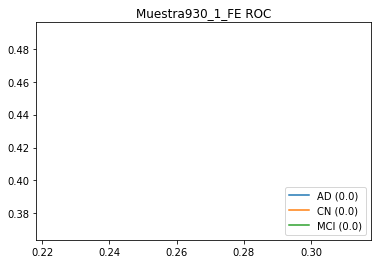

In [25]:
def sortByX(point):
  return point[0]

# Se necesita ordenar los puntos para llamar a torch.trapezoid con los puntos ordenados por la coordenada X
def sortListsByX(x, y):
    points = zip(x, y)
    points = list(points)
    points.sort(key=sortByX)
    x, y = ([ a for a,b in points ], [ b for a,b in points ])
    return x, y

fig = plt.figure()
ad_y = ad_tpr = [ x["recall"] for x in adStatValues ]
ad_x = ad_fpr = [ 1.0 - x["specificity"] for x in adStatValues ]
ad_x, ad_y = sortListsByX(ad_x, ad_y)

cn_y = cn_tpr = [ x["recall"] for x in cnStatValues ]
cn_x = cn_fpr = [ 1.0 - x["specificity"] for x in cnStatValues ]
cn_x, cn_y = sortListsByX(cn_x, cn_y)

mci_y = mci_tpr = [ x["recall"] for x in mciStatValues ]
mci_x = mci_fpr = [ 1.0 - x["specificity"] for x in mciStatValues ]
mci_x, mci_y = sortListsByX(mci_x, mci_y)

decimals = 3
ad_auc = round(torch.trapezoid(torch.tensor(ad_y), torch.tensor(ad_x)).item(), decimals)
cn_auc = round(torch.trapezoid(torch.tensor(cn_y), torch.tensor(cn_x)).item(), decimals)
mci_auc = round(torch.trapezoid(torch.tensor(mci_y), torch.tensor(mci_x)).item(), decimals)

plt.title(experimentName + " ROC")

plt.plot(ad_fpr, ad_tpr)
plt.plot(cn_fpr, cn_tpr)
plt.plot(mci_fpr, mci_tpr)

plt.legend(["AD ("+str(ad_auc)+")", "CN ("+str(cn_auc)+")", "MCI ("+str(mci_auc)+")"], loc ="lower right")

plt.show()